<a href="https://colab.research.google.com/github/elianramon/I2A2_final_project/blob/main/Classificador_e_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import drive
import unicodedata # Para limpar nomes de estados
from sklearn.impute import SimpleImputer # Para tratar NaNs

from sklearn.ensemble import RandomForestClassifier #Classificar agora
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE #Para balancear

In [ ]:
# Substitua a URL pelo link HTTPS do seu repositório
!git clone https://github.com/elianramon/I2A2_final_project.git

Cloning into 'I2A2_final_project'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 34 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 60.73 KiB | 3.20 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
import os

base_path = 'I2A2_final_project/Datasets'   # Imports do github
print(os.listdir(base_path))

['inpe_brazilian_amazon_fires_1999_2019.csv', 'preco_soja.csv', 'el_nino_la_nina_1999_2019.csv', 'preco_boi.csv', 'def_area_2004_2019.csv']


In [ ]:
path_area = (f'{base_path}/def_area_2004_2019.csv')
path_fires = (f'{base_path}/inpe_brazilian_amazon_fires_1999_2019.csv')
path_climate = (f'{base_path}/el_nino_la_nina_1999_2019.csv')
path_soja = (f'{base_path}/preco_soja.csv')
path_gado = (f'{base_path}/preco_boi.csv')

In [ ]:
path_area
df_area = pd.read_csv(path_area)

Dataset 'Área Desmatada' (Alvo) carregado. (16, 11)
Dataset 'Incêndios' (Feature 1) carregado. (2104, 6)
Dataset 'Clima' (Feature 2) carregado. (16, 4)
Dataset 'Preço Soja' (Feature 3) carregado. (429, 3)
Dataset 'Preço Gado' (Feature 4) carregado. (429, 3)

--- 2. Preparando e Unindo Features (por Estado) ---
Features de 'Incêndio' agregadas por ano E estado.
Processando dados de commodities (Soja e Gado)...
Features de 'Commodities' agregadas por ano.
Datasets (incluindo commodities) unidos com sucesso. Novo dataset tem (144, 10) linhas.
Dataset final pronto para o modelo:
   year state_abbr  area_desmatada_km2 state_norm state_y  total_focos_estado  \
0  2004         AC                 728       acre    ACRE              7271.0   
1  2005         AC                 592       acre    ACRE             15993.0   
2  2006         AC                 398       acre    ACRE              6198.0   
3  2007         AC                 184       acre    ACRE              8549.0   
4  2008      

/tmp/ipython-input-949880215.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_soja_raw['date'] = pd.to_datetime(df_soja_raw['date'], dayfirst=True)
/tmp/ipython-input-949880215.py:68: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_gado_raw['date'] = pd.to_datetime(df_gado_raw['date'], dayfirst=True)


Modelo treinado com sucesso!

--- 4. Avaliação do Modelo ---
R² Score (R-squared): 0.7083
RMSE (Erro Médio): 1276.38 km²

(R² de 0.71 significa que o modelo explica ~71% da variação nos dados de desmatamento.)

--- 5. Gerando Gráficos ---


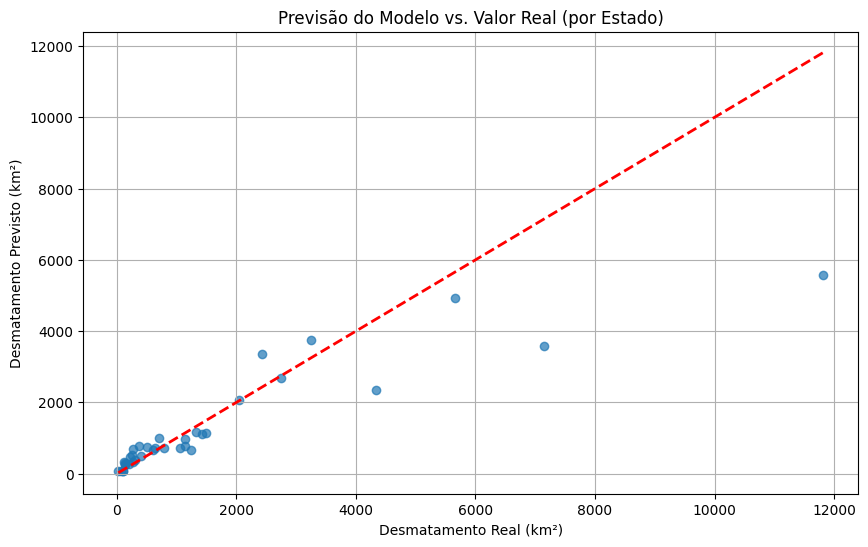

/tmp/ipython-input-949880215.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')


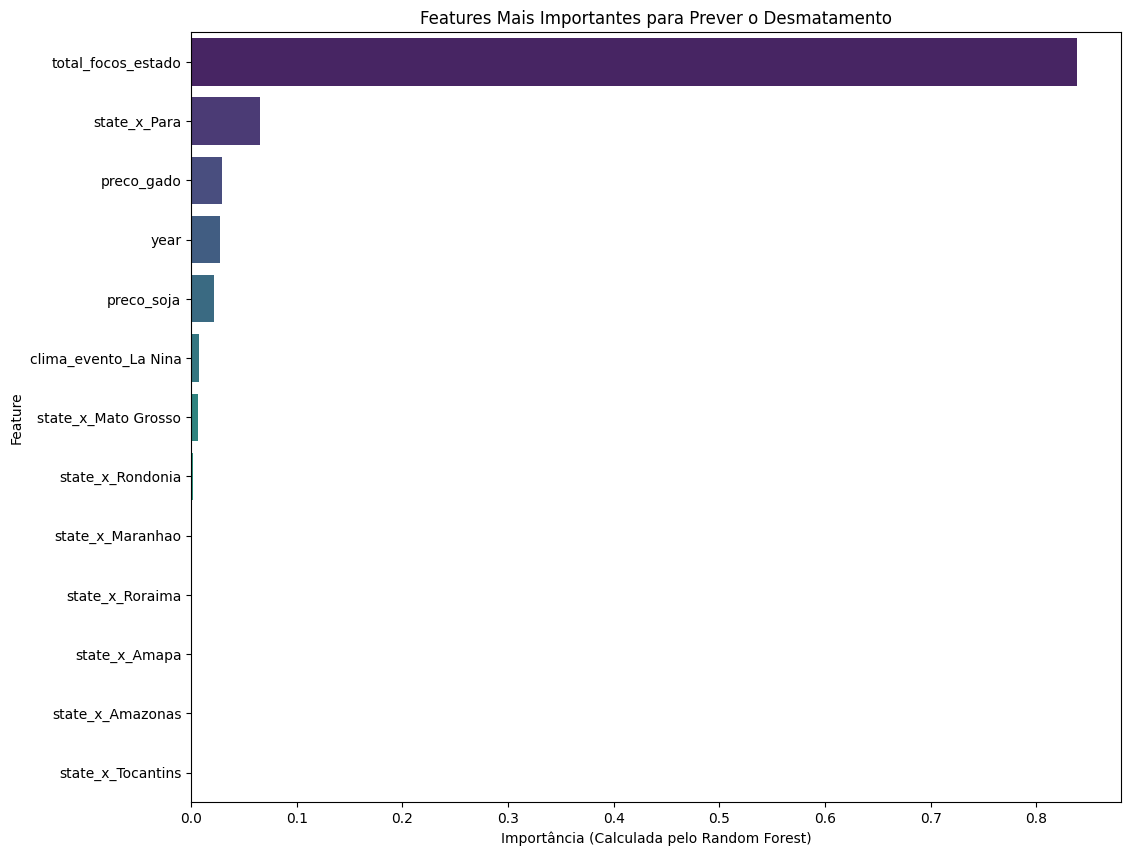

In [ ]:
try:
    df_area = pd.read_csv(path_area)
    df_area = df_area.rename(columns={'Ano/Estados': 'year'})
    print(f"Dataset 'Área Desmatada' (Alvo) carregado. {df_area.shape}")

    df_fires = pd.read_csv(path_fires, encoding='latin-1')
    print(f"Dataset 'Incêndios' (Feature 1) carregado. {df_fires.shape}")

    df_climate = pd.read_csv(path_climate)
    df_climate = df_climate.rename(columns={'start year': 'year', 'phenomenon': 'clima_evento'})
    print(f"Dataset 'Clima' (Feature 2) carregado. {df_climate.shape}")

    df_soja_raw = pd.read_csv(path_soja, encoding='latin-1', sep=';', decimal=',', skiprows=2, header=None)
    print(f"Dataset 'Preço Soja' (Feature 3) carregado. {df_soja_raw.shape}")

    df_gado_raw = pd.read_csv(path_gado, encoding='latin-1', sep=';', decimal=',', skiprows=2, header=None)
    print(f"Dataset 'Preço Gado' (Feature 4) carregado. {df_gado_raw.shape}")

except Exception as e:
    print(f"\n--- ERRO ---")
    print(f"Erro ao carregar arquivos: {e}")
    # CORREÇÃO: Sugerir os nomes de arquivo usados no código
    print("Verifique se os nomes 'preco_soja.csv' e 'preco_boi.csv' e o valor de 'base_path' estão corretos.")
    exit()

# Engenharia de Features
print("\n--- 2. Preparando e Unindo Features (por Estado) ---")

# Preparar DF de ÁREA (Alvo) ---
estados_abbr = ['AC', 'AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO']
df_area_melted = df_area.melt(
    id_vars=['year'],
    value_vars=estados_abbr,
    var_name='state_abbr',
    value_name='area_desmatada_km2'
)

# Preparar DF de INCÊNDIOS (Feature 1)
if df_fires['firespots'].dtype == 'object':
    df_fires['firespots'] = df_fires['firespots'].str.replace('.', '', regex=False).astype(float)
else:
    df_fires['firespots'] = df_fires['firespots'].astype(float)

df_fires_agg = df_fires.groupby(['year', 'state'])['firespots'].sum().reset_index()
df_fires_agg = df_fires_agg.rename(columns={'firespots': 'total_focos_estado'})
print("Features de 'Incêndio' agregadas por ano E estado.")

# Preparar DF de CLIMA (Feature 2)
df_climate = df_climate[['year', 'clima_evento']]

# Preparar DF de COMMODITIES (Features 3 e 4)
print("Processando dados de commodities (Soja e Gado)...")

NOME_DATA_SOJA = 0
NOME_VALOR_SOJA = 1
NOME_DATA_GADO = 0
NOME_VALOR_GADO = 1

try:
    # Processar Soja
    df_soja_raw = df_soja_raw.rename(columns={NOME_DATA_SOJA: 'date', NOME_VALOR_SOJA: 'preco_soja'})
    df_soja_raw['date'] = pd.to_datetime(df_soja_raw['date'], dayfirst=True)
    df_soja_raw['year'] = df_soja_raw['date'].dt.year
    df_soja_anual = df_soja_raw.groupby('year')['preco_soja'].mean().reset_index()

    # Processar Gado
    df_gado_raw = df_gado_raw.rename(columns={NOME_DATA_GADO: 'date', NOME_VALOR_GADO: 'preco_gado'})
    df_gado_raw['date'] = pd.to_datetime(df_gado_raw['date'], dayfirst=True)
    df_gado_raw['year'] = df_gado_raw['date'].dt.year
    df_gado_anual = df_gado_raw.groupby('year')['preco_gado'].mean().reset_index()

    print("Features de 'Commodities' agregadas por ano.")

except KeyError as e:
    print(f"\n--- ERRO DE KEYERROR ---")
    print(f"A coluna {e} não foi encontrada.")
    exit()


# Unir (Merge) os DataFrames
state_map = {
    'AC': 'Acre', 'AM': 'Amazonas', 'AP': 'Amapa', 'MA': 'Maranhao',
    'MT': 'Mato Grosso', 'PA': 'Para', 'RO': 'Rondonia', 'RR': 'Roraima', 'TO': 'Tocantins'
}
df_area_melted['state'] = df_area_melted['state_abbr'].map(state_map)

def normalize_text(s):
    if isinstance(s, str):
        s = s.lower()
        s = unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode('utf-8')
        return s
    return s

df_area_melted['state_norm'] = df_area_melted['state'].apply(normalize_text)
df_fires_agg['state_norm'] = df_fires_agg['state'].apply(normalize_text)

# Unir área + incêndios
df_merged = pd.merge(
    df_area_melted,
    df_fires_agg,
    on=['year', 'state_norm'],
    how='inner'
)
# Unir com clima
df_final = pd.merge(
    df_merged,
    df_climate,
    on='year',
    how='left'
)
# Unir com commodities (Soja)
df_final = pd.merge(
    df_final,
    df_soja_anual,
    on='year',
    how='left'
)
# Unir com commodities (Gado)
df_final = pd.merge(
    df_final,
    df_gado_anual,
    on='year',
    how='left'
)
print(f"Datasets (incluindo commodities) unidos com sucesso. Novo dataset tem {df_final.shape} linhas.")

# Preparar Features Finais
df_final = pd.get_dummies(df_final, columns=['state_x', 'clima_evento'], drop_first=True, dtype=int)
df_final['year'] = df_final['year'].astype(int)

print("Dataset final pronto para o modelo:")
print(df_final.head())


# Treinamento do Modelo (Random Forest Regressor)
print("\n--- 3. Treinando Modelo ---")

y = df_final['area_desmatada_km2']
X = df_final.drop(columns=[
    'area_desmatada_km2', 'state_abbr', 'state_norm',
    'state', 'state_y'
], errors='ignore')

# Tratar NaNs criados pelo 'how=left' (para anos onde não há preço)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Treinando com {len(X_train)} amostras.")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("Modelo treinado com sucesso!")


# valiação do Modelo
print("\n--- 4. Avaliação do Modelo ---")

y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score (R-squared): {r2:.4f}")
print(f"RMSE (Erro Médio): {rmse:.2f} km²")
print(f"\n(R² de {r2:.2f} significa que o modelo explica ~{r2*100:.0f}% da variação nos dados de desmatamento.)")

# Visualização dos Resultados
print("\n--- 5. Gerando Gráficos ---")

# Gráfico 1: Previsão vs. Real
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Previsão do Modelo vs. Valor Real (por Estado)')
plt.xlabel('Desmatamento Real (km²)')
plt.ylabel('Desmatamento Previsto (km²)')
plt.grid(True)
plt.show()

# Gráfico 2: Features Mais Importantes
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Features Mais Importantes para Prever o Desmatamento')
plt.xlabel('Importância (Calculada pelo Random Forest)')
plt.ylabel('Feature')
plt.show()

# Teste 2

In [ ]:
# --- Imports no início ---

Todos os 5 arquivos carregados com sucesso.

--- 2. Preparando e Unindo Features (por Estado) ---
Features de 'Incêndio' agregadas por ano E estado.
Processando dados de commodities (Soja e Gado)...
Features de 'Commodities' agregadas por ano.
Datasets (incluindo commodities) unidos com sucesso. Novo dataset tem (144, 10) linhas.
Dataset final pronto para o modelo:

--- 3. Treinando Modelo ---
Classes de Risco (Alvo Y) criadas:
risco_desmatamento
Baixo    48
Medio    48
Alto     48
Name: count, dtype: int64

Aplicando SMOTE para balancear os dados de treino...
Novas contagens de treino (balanceado): 
risco_desmatamento
Baixo    36
Medio    36
Alto     36
Name: count, dtype: int64
Treinando com 108 amostras (balanceadas).


/tmp/ipython-input-3631415358.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_soja_raw['date'] = pd.to_datetime(df_soja_raw['date'], dayfirst=True)
/tmp/ipython-input-3631415358.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_gado_raw['date'] = pd.to_datetime(df_gado_raw['date'], dayfirst=True)


Modelo treinado com sucesso!

--- 4. Avaliação do Modelo ---
Acurácia (Accuracy): 77.78%

Relatório de Classificação:
              precision    recall  f1-score   support

        Alto       0.91      0.83      0.87        12
       Baixo       0.82      0.75      0.78        12
       Medio       0.64      0.75      0.69        12

    accuracy                           0.78        36
   macro avg       0.79      0.78      0.78        36
weighted avg       0.79      0.78      0.78        36


--- 5. Gerando Gráficos ---
Gerando Matriz de Confusão...


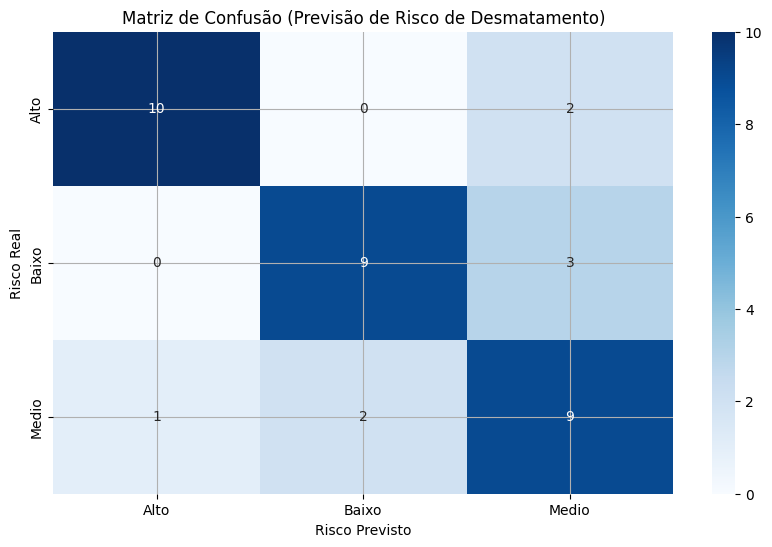

/tmp/ipython-input-3631415358.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')


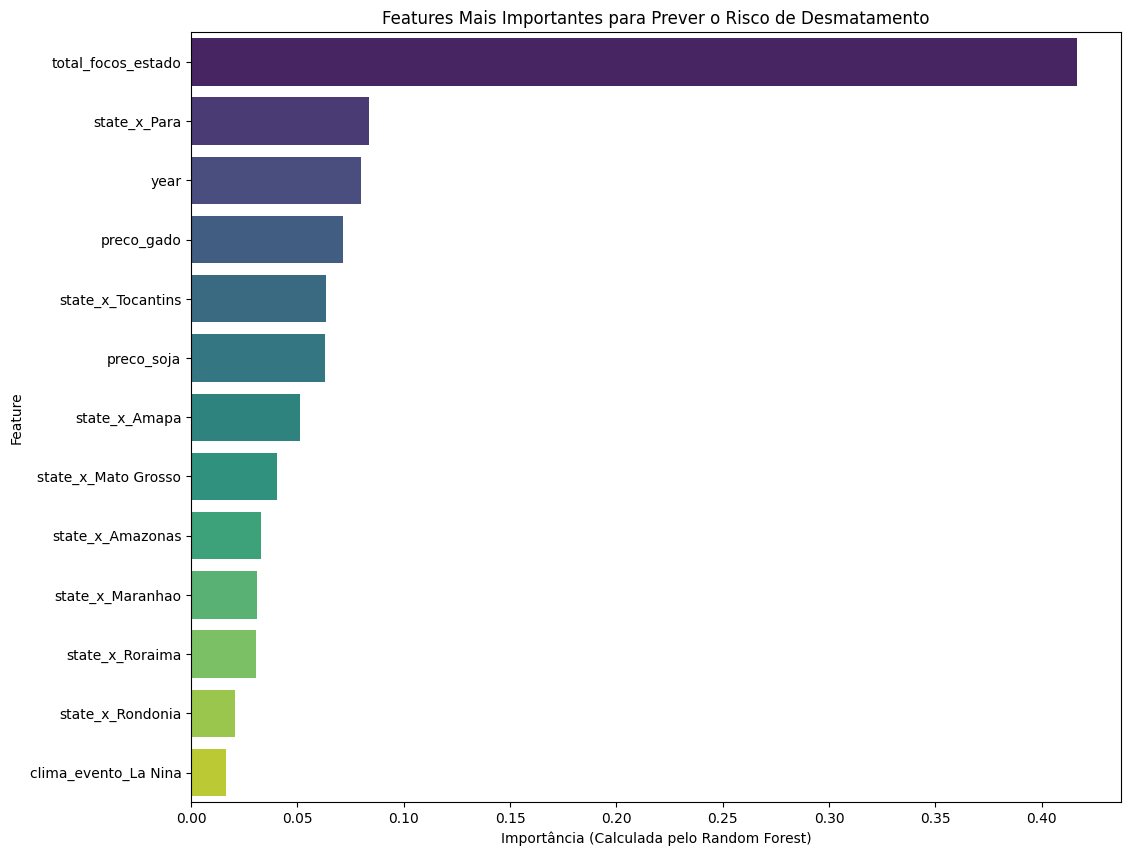

In [ ]:
path_area = (f'{base_path}/def_area_2004_2019.csv')
path_fires = (f'{base_path}/inpe_brazilian_amazon_fires_1999_2019.csv')
path_climate = (f'{base_path}/el_nino_la_nina_1999_2019.csv')
path_soja = (f'{base_path}/preco_soja.csv')
path_gado = (f'{base_path}/preco_boi.csv')

try:
    df_area = pd.read_csv(path_area)
    df_area = df_area.rename(columns={'Ano/Estados': 'year'})
    df_fires = pd.read_csv(path_fires, encoding='latin-1')
    df_climate = pd.read_csv(path_climate)
    df_climate = df_climate.rename(columns={'start year': 'year', 'phenomenon': 'clima_evento'})
    df_soja_raw = pd.read_csv(path_soja, encoding='latin-1', sep=';', decimal=',', skiprows=2, header=None)
    df_gado_raw = pd.read_csv(path_gado, encoding='latin-1', sep=';', decimal=',', skiprows=2, header=None)
    print("Todos os 5 arquivos carregados com sucesso.")
except Exception as e:
    print(f"\n--- ERRO ---")
    print(f"Erro ao carregar arquivos: {e}")
    exit()

# Engenharia de Features
print("\n--- 2. Preparando e Unindo Features (por Estado) ---")


estados_abbr = ['AC', 'AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO']
df_area_melted = df_area.melt(
    id_vars=['year'],
    value_vars=estados_abbr,
    var_name='state_abbr',
    value_name='area_desmatada_km2'
)

# Preparar DF de INCÊNDIOS (Feature 1)
if df_fires['firespots'].dtype == 'object':
    df_fires['firespots'] = df_fires['firespots'].str.replace('.', '', regex=False).astype(float)
else:
    df_fires['firespots'] = df_fires['firespots'].astype(float)
df_fires_agg = df_fires.groupby(['year', 'state'])['firespots'].sum().reset_index()
df_fires_agg = df_fires_agg.rename(columns={'firespots': 'total_focos_estado'})
print("Features de 'Incêndio' agregadas por ano E estado.")

# Preparar DF de CLIMA (Feature 2)
df_climate = df_climate[['year', 'clima_evento']]

# Preparar DF de COMMODITIES (Features 3 e 4)
print("Processando dados de commodities (Soja e Gado)...")
try:
    df_soja_raw = df_soja_raw.rename(columns={0: 'date', 1: 'preco_soja'})
    df_soja_raw['date'] = pd.to_datetime(df_soja_raw['date'], dayfirst=True)
    df_soja_raw['year'] = df_soja_raw['date'].dt.year
    df_soja_anual = df_soja_raw.groupby('year')['preco_soja'].mean().reset_index()

    df_gado_raw = df_gado_raw.rename(columns={0: 'date', 1: 'preco_gado'})
    df_gado_raw['date'] = pd.to_datetime(df_gado_raw['date'], dayfirst=True)
    df_gado_raw['year'] = df_gado_raw['date'].dt.year
    df_gado_anual = df_gado_raw.groupby('year')['preco_gado'].mean().reset_index()
    print("Features de 'Commodities' agregadas por ano.")
except KeyError as e:
    print(f"\n--- ERRO DE KEYERROR ---")
    print(f"A coluna {e} não foi encontrada.")
    exit()


# Unir (Merge) os DataFrames
state_map = {
    'AC': 'Acre', 'AM': 'Amazonas', 'AP': 'Amapa', 'MA': 'Maranhao',
    'MT': 'Mato Grosso', 'PA': 'Para', 'RO': 'Rondonia', 'RR': 'Roraima', 'TO': 'Tocantins'
}
df_area_melted['state'] = df_area_melted['state_abbr'].map(state_map)
def normalize_text(s):
    if isinstance(s, str):
        s = s.lower()
        s = unicodedata.normalize('NFD', s).encode('ascii', 'ignore').decode('utf-8')
        return s
    return s
df_area_melted['state_norm'] = df_area_melted['state'].apply(normalize_text)
df_fires_agg['state_norm'] = df_fires_agg['state'].apply(normalize_text)

df_merged = pd.merge(df_area_melted, df_fires_agg, on=['year', 'state_norm'], how='inner')
df_final = pd.merge(df_merged, df_climate, on='year', how='left')
df_final = pd.merge(df_final, df_soja_anual, on='year', how='left')
df_final = pd.merge(df_final, df_gado_anual, on='year', how='left')
print(f"Datasets (incluindo commodities) unidos com sucesso. Novo dataset tem {df_final.shape} linhas.")

# Preparar Features Finais
df_final = pd.get_dummies(df_final, columns=['state_x', 'clima_evento'], drop_first=True, dtype=int)
df_final['year'] = df_final['year'].astype(int)

print("Dataset final pronto para o modelo:")


# Treinamento do Modelo (Random Forest CLASSIFIER)
print("\n--- 3. Treinando Modelo ---")

# Em vez de prever o número, vamos prever 3 "Classes de Risco"
# Usamos qcut para criar 3 grupos de tamanho igual (Baixo, Médio, Alto)
try:
    df_final['risco_desmatamento'] = pd.qcut(df_final['area_desmatada_km2'],
                                             q=3,
                                             labels=['Baixo', 'Medio', 'Alto'])
except ValueError:
    # Se houver muitos valores duplicados (ex: 0.0), o qcut falha. Usamos rank=first
    df_final['risco_desmatamento'] = pd.qcut(df_final['area_desmatada_km2'].rank(method='first'),
                                             q=3,
                                             labels=['Baixo', 'Medio', 'Alto'])

y = df_final['risco_desmatamento']
print("Classes de Risco (Alvo Y) criadas:")
print(y.value_counts())

# As Features (X) são todo o resto
X = df_final.drop(columns=[
    'area_desmatada_km2', 'risco_desmatamento', # Dropar o alvo numérico E o categórico
    'state_abbr', 'state_norm',
    'state', 'state_y'
], errors='ignore')

# Tratar NaNs criados pelo 'how=left' (para anos onde não há preço)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Dividir ANTES de aplicar SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("\nAplicando SMOTE para balancear os dados de treino...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Novas contagens de treino (balanceado): \n{pd.Series(y_train_res).value_counts()}")

print(f"Treinando com {len(X_train_res)} amostras (balanceadas).")

# Clsssificar agora
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# Treinar nos dados balanceados (resampled)
rf_model.fit(X_train_res, y_train_res)
print("Modelo treinado com sucesso!")


# Avaliação do modelo
print("\n--- 4. Avaliação do Modelo ---")

# Prever no X_test original
y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia (Accuracy): {acc * 100:.2f}%")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


# Resultados
print("\n--- 5. Gerando Gráficos ---")

# Matriz de Confusão
print("Gerando Matriz de Confusão...")
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Matriz de Confusão (Previsão de Risco de Desmatamento)')
plt.xlabel('Risco Previsto')
plt.ylabel('Risco Real')
plt.grid(True)
plt.show()

# Gráfico 2: Features Mais Importantes
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Features Mais Importantes para Prever o Risco de Desmatamento')
plt.xlabel('Importância (Calculada pelo Random Forest)')
plt.ylabel('Feature')
plt.show()

In [ ]:
import numpy as np

np.random.randint(low=10, high=20, size=100)

array([19, 10, 15, 14, 18, 11, 18, 19, 17, 14, 19, 13, 15, 17, 16, 10, 12,
       10, 10, 10, 10, 15, 13, 13, 13, 17, 11, 11, 16, 19, 16, 16, 18, 15,
       15, 13, 12, 13, 11, 10, 12, 18, 11, 12, 18, 15, 10, 12, 13, 13, 11,
       15, 10, 14, 15, 15, 17, 17, 14, 13, 17, 14, 14, 14, 11, 17, 18, 14,
       13, 19, 11, 18, 19, 12, 11, 10, 11, 19, 12, 10, 17, 10, 15, 15, 19,
       14, 15, 13, 14, 19, 12, 12, 11, 14, 15, 13, 19, 17, 16, 17])